# Project: Adversarial BayesFlow

# Experiment 2: MVN means and full covariance

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats
from functools import partial

from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

from abf_functions import *

RERUN_GRID_EXPERIMENT = False

In [2]:
plt.rcParams.update({
    "axes.labelsize" : 20,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

FILEFORMAT = 'pdf'
DPI = 300

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [4]:
D = 5

#########

class NormalInverseWishartPrior:
    def __init__(self, D, mu_0=0.0, lamda_0=1.0, Psi_0=None, nu_0=None):
        if Psi_0 is None:
            Psi_0 = np.eye(D)
        if nu_0 is None:
            nu_0 = D+1
        self.D = D,
        self.mu_0 = mu_0
        self.lamda_0 = lamda_0
        self.Psi_0 = Psi_0
        self.nu_0 = nu_0
        
        self.cov_prior = stats.invwishart(self.nu_0, self.Psi_0)
        
    def __call__(self, n_sim):
        cov = self.cov_prior.rvs(n_sim)
        tril_cov = tf.linalg.cholesky((1.0 / self.lamda_0) * cov)
        means = tfp.distributions.MultivariateNormalTriL(self.mu_0, tril_cov).sample()
        
        return np.array(means, dtype=np.float32), np.array(cov, dtype=np.float32)


def param_transform_full_cov(theta):
    means, cov = theta
    means = np.array(means)
    n_sim, D = means.shape
    cov = np.array(cov)
    cov = cov[np.tril(cov).nonzero()].reshape(n_sim, -1)
    return np.concatenate([means, cov], axis=1)


mu_0 = 0.0
lamda_0 = 5
Psi_0 = np.eye(D)
nu_0 = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0, lamda_0=lamda_0, Psi_0=Psi_0, nu_0=nu_0)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 64},
    'dense_s2_args': {'activation': 'relu', 'units': 64},
    'dense_s3_args': {'activation': 'relu', 'units': 64},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=(sum(range(1, D+1)) + D),  
                                   activation_out=None  # linear
)


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': sum(range(1, D+1)) + D,   # lower diagonal cov (1+2+...+D) and D means
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0005,
                      checkpoint_path='export_ckpt/mmd/full_cov_5D',
                      max_to_keep = 2
                     )

Initializing networks from scratch.


In [5]:
losses = trainer.train_rounds(epochs=10, rounds=10, sim_per_round=10000, batch_size=128, n_obs=100)

Simulating initial 10000 data sets...
Converting 10000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 20000
Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 30000
Converting 30000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 40000
Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 50000
Converting 50000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 60000
Converting 60000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 70000
Converting 70000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/547 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 80000
Converting 80000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 90000
Converting 90000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 100000
Converting 100000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

In [6]:
def param_list_to_mean_cov(theta, D):
    # setup
    n_sim = theta.shape[0]
    mean = theta[:, :D]
    cov_list = theta[:, D:]
    tril_idx1, tril_idx2 = np.tril_indices(D)
    cov = np.zeros((n_sim, D, D))
    
    # fill cov matrix
    for i in range(n_sim):
        # write from flattened array into in lower triangular matrix
        cov[i, tril_idx1, tril_idx2] = cov_list[i, :]
        
        # mirror lower triangular matrix to upper triangle
        cov[i] = cov[i] + cov[i].T - np.diag(np.diag(cov[i]))
    return mean, cov

def cov_to_corr(cov, std_devs_on_diagonal=True, epsilon=1e-6):
    corr = np.zeros_like(cov)
    n_sim = cov.shape[0]
    
    for i in range(n_sim):
        # extract 2D matrix
        Sigma = cov[i, :, :]
        
        # transform 2D cov matrix into corr matrix
        std_devs = np.sqrt(np.maximum(np.diag(Sigma), epsilon))
        Dinv = np.diag(1 / std_devs)
        corr[i] = Dinv @ Sigma @ Dinv
        
        # increase information by putting SDs on diagonal instead of 1's
        if std_devs_on_diagonal:
            np.fill_diagonal(corr[i], std_devs)
            
    return corr

def theta_cov_to_corr(theta, D):
    mean, cov = param_list_to_mean_cov(theta, D=D)
    corr = cov_to_corr(cov)
    theta_corr = param_transform_full_cov((mean, corr))
    return theta_corr

def true_vs_estimated_tril(theta_true, theta_est, param_names, D, dpi=300,
                      figsize=(20, 4), show=True, filename=None, font_size=12):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values.

    Parameters
    ----------
    theta_true: np.array
        Array of true parameters.
    theta_est: np.array
        Array of estimated parameters.
    param_names: list
        List of parameter names for plotting.
    D : int
        Number of dimensions of parameters.
    dpi: int, default:300
        Dots per inch (dpi) for the plot.
    figsize: tuple(int, int), default: (20,4)
        Figure size.
    show: boolean, default: True
        Controls if the plot will be shown
    filename: str, default: None
        Filename if plot shall be saved
    font_size: int, default: 12
        Font size

    """
    
    idx = 0

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Determine n_subplots dynamically
    n_row = D+1
    n_col = D

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
        
    # --- Plot true vs estimated posterior means on a single row --- #
    
    for i in range(n_row):
        for j in range(n_col):
            if j>(i-1) and i != 0:
                axarr[i, j].axis('off')
            else:
                # Plot analytic vs estimated
                axarr[i, j].scatter(theta_est[:, idx], theta_true[:, idx], color='black', alpha=0.4)

                # get axis limits and set equal x and y limits
                lower_lim = min(axarr[i, j].get_xlim()[0], axarr[i, j].get_ylim()[0])
                upper_lim = max(axarr[i, j].get_xlim()[1], axarr[i, j].get_ylim()[1])
                axarr[i, j].set_xlim((lower_lim, upper_lim))
                axarr[i, j].set_ylim((lower_lim, upper_lim))
                axarr[i, j].plot(axarr[i, j].get_xlim(), axarr[i, j].get_xlim(), '--', color='black')

                # Compute NRMSE
                rmse = np.sqrt(np.mean( (theta_est[:, idx] - theta_true[:, idx])**2 ))
                nrmse = rmse / (theta_true[:, idx].max() - theta_true[:, idx].min())
                axarr[i, j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                             horizontalalignment='left',
                             verticalalignment='center',
                             transform=axarr[i, j].transAxes,
                             size=10)

                # Compute R2
                #r2 = r2_score(theta_true[:, j], theta_est[:, j])
                #axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                #             horizontalalignment='left',
                #             verticalalignment='center',
                #             transform=axarr[j].transAxes, 
                #             size=10)

                if j == 0 and i == 0 or 0==0:
                    # Label plot
                    axarr[i, j].set_xlabel('Estimated')
                    axarr[i, j].set_ylabel('True')
                axarr[i, j].set_title(param_names[idx])
                axarr[i, j].spines['right'].set_visible(False)
                axarr[i, j].spines['top'].set_visible(False)
                
                idx += 1
    
    # Adjust spaces
    f.tight_layout()
    
    if filename is not None:
        f.savefig(filename)

    if show:
        plt.show()



### Analytic posterior

In [7]:
def analytic_joint_posterior_normal_inverse_wishart(X, mu_0, lamda_0, Psi_0, nu_0):
    n_sim, n_obs, D = X.shape
    mu_n = [None] * n_sim
    lamda_n = [None] * n_sim
    Psi_n = [None] * n_sim
    nu_n = [None] * n_sim
    
    for i in range(n_sim):
        x = X[i, :, :]
        x_bar = np.mean(x, axis=0)
        C = np.dot((x-x_bar).T, x-x_bar)
        
        mu_n[i] = (lamda_0 * mu_0 + n_obs*x_bar) / (lamda_0 + n_obs)
        lamda_n[i] = lamda_0 + n_obs
        nu_n[i] = nu_0 + n_obs
        Psi_n[i] = Psi_0 + C + ((lamda_0*n_obs)/(lamda_0+n_obs)) * np.dot(x_bar-mu_0, (x_bar-mu_0).T)
        
    return mu_n, lamda_n, Psi_n, nu_n


def marginal_posterior_normal_inverse_wishart(mu_n, lamda_n, Psi_n, nu_n):
    D = mu_n[0].shape[0]
    n_sim = len(mu_n)
    
    marginal_mu_distributions = [None] * n_sim
    marginal_Sigma_distributions = [None] * n_sim

    for i in range(n_sim):
        # mu_p
        marginal_mu_distributions[i] = stats.multivariate_t(
            loc=mu_n[i], 
            shape=np.linalg.inv(Psi_n[i]) / (lamda_n[i]*(nu_n[i] - D + 1)), 
            df=nu_n[i] - D + 1
        )
        
        # Sigma_p
        marginal_Sigma_distributions[i] = stats.invwishart(nu_n[i], Psi_n[i])
    
    return marginal_mu_distributions, marginal_Sigma_distributions

In [8]:
def adversarial_diagnostics_mvn_full_cov(trainer, theta, x, mu_0=0.0, lamda_0=5, Psi_0=np.eye(5), nu_0=10, 
                                         print_plots=False, filename=None):
    param_samples = trainer.network.sample(x, n_samples=300)
    param_means = np.mean(param_samples, axis=1)

    param_means = theta_cov_to_corr(param_means, D=D)

    mu_n, lamda_n, Psi_n, nu_n = analytic_joint_posterior_normal_inverse_wishart(x, mu_0, lamda_0, Psi_0, nu_0)

    marginal_mu_p, marginal_Sigma_p = marginal_posterior_normal_inverse_wishart(mu_n, lamda_n, Psi_n, nu_n)

    mu_p_means = np.array([dist.loc for dist in marginal_mu_p])
    Sigma_p_covs = np.array([marginal_Sigma_p[i].scale / (nu_n[i]-D-1) for i in range(len(marginal_Sigma_p))])

    theta_analytical_posterior = param_transform_full_cov((mu_p_means, Sigma_p_covs))
    theta_analytical_posterior = theta_cov_to_corr(theta_analytical_posterior, D=D)

    param_names = [r'$\mu_%i$'%i for i in range(1, D+1)] + \
    [r'$\sigma_%i$'%(i+1) if i==j else r'cor$_{%i%i}$'%(i+1, j+1) for (i, j) in zip(*np.tril_indices(D))]

    # analytical posterior
    true_vs_estimated_tril(theta_analytical_posterior, param_means, param_names, D, figsize=(20,20), filename=f"{filename}_true_analytic.{FILEFORMAT}")

        
    
    if print_plots:
        s = np.array(trainer.network.summary_net(x))
        sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")
        if filename is not None:
            plt.savefig(f"{filename}_summary_response.{FILEFORMAT}")

### (A0) Baseline

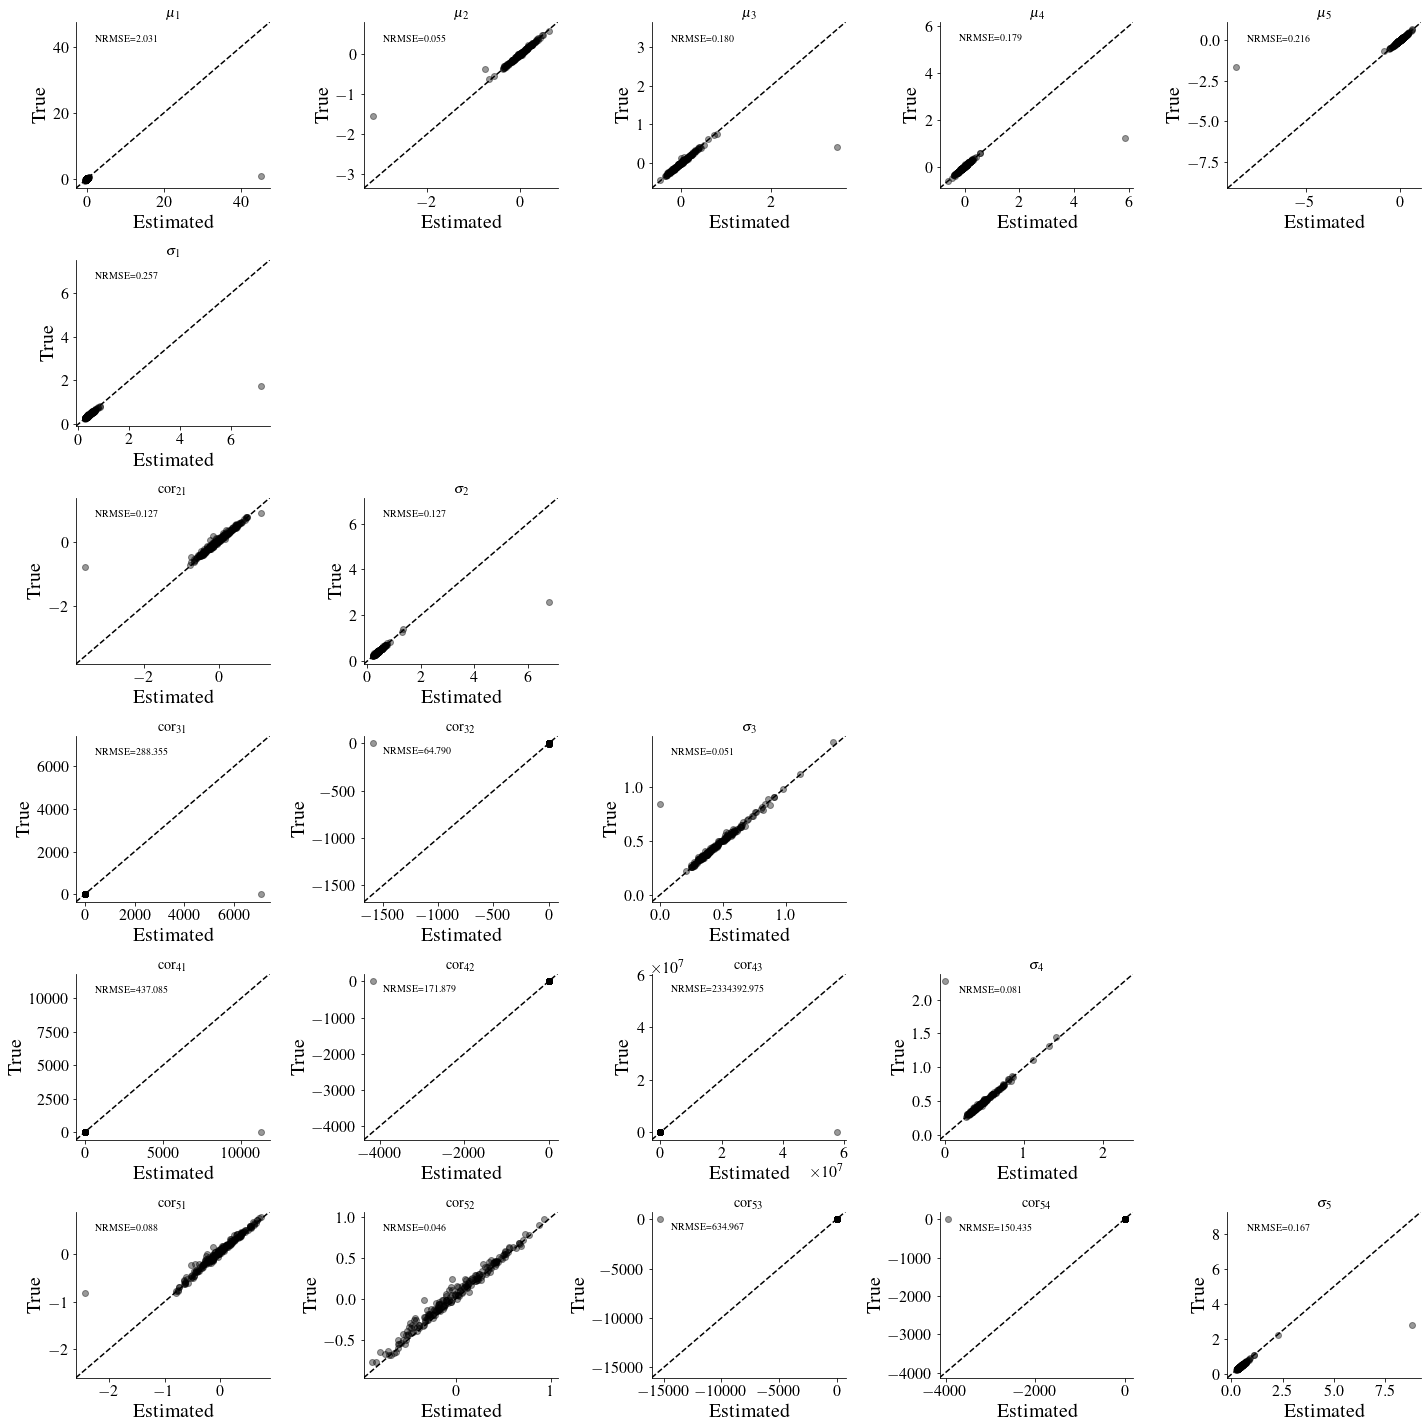

In [9]:
mu_0o = 0.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)

adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_baseline")

### (A1) - c

In [ ]:
mu_0o = 2
lamda_0o = 5
Psi_0o = 1.5 * np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)


adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_prior")

### (A2)

$\boldsymbol{x}^{(i)}\sim t_2(\boldsymbol{\mu}^{(i)}, \boldsymbol{\Sigma}^{(i)})$

In [ ]:
class MultivariateTSimulatorFullCov:
    def __init__(self, df=2):
        self.df = df

    def simulate_data(self, mean, cov, n_obs):
        x = stats.multivariate_t(loc=mean, shape=cov, df=self.df).rvs(n_obs)
        return x

    def generate_multiple_datasets(self, p_samples, n_obs):
        mean, cov = p_samples
        n_sim = mean.shape[0]
        theta_dim = mean.shape[1]
        sim_data = np.zeros((n_sim, n_obs, theta_dim))

        for bi in range(n_sim):
            sim_data[bi] = self.simulate_data(mean[bi], cov[bi], n_obs)
        return sim_data.astype(np.float32)

    def __call__(self, p_samples, n_obs):
        return self.generate_multiple_datasets(p_samples, n_obs)

In [ ]:
mu_0o = 1.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = MultivariateTSimulatorFullCov(df=2)
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)


adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_simulator")

## (A3) Contamination

In [ ]:
mu_0o = 0.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)

n_sim, n_obs, data_dim = x.shape


lamda = 0.5

x = noisify_x(x, lamda = lamda,
                      noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=1))

adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_noise")

# Summary space: MD and MMD plots

In [ ]:
lamda_0 = 5
nu_0 = 10

n_loc = 101
n_scale = 101
prior_loc = np.linspace(-6.0, 6.0, num = n_loc)
prior_scale = np.linspace(0.10, 5.90, num = n_scale)
P1, P2 = np.meshgrid(prior_loc, prior_scale)

if RERUN_GRID_EXPERIMENT:
    _, x_star = trainer._forward_inference(200, 100)
    s_star = np.array(trainer.network.summary_net(x_star))

    MMD = np.zeros((n_scale, n_loc))
    for i in tqdm(range(n_scale)):
        for j in range(n_loc):
            p1 = P1[i, j]
            p2 = P2[i, j]
            prior = NormalInverseWishartPrior(D=D, mu_0=p1, lamda_0=lamda_0, Psi_0=p2 * np.eye(D), nu_0=nu_0)
            simulator = GaussianMeanCovSimulator()
            generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)
            _, x_o = generative_model(200, 100)
            s_o = np.array(trainer.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, s_star, squared=False))
    np.save(f"data/MMD_grid_experiments/MVN_full_MMD_grid_prior.npy", MMD)
    
MMD = np.load(f"data/MMD_grid_experiments/MVN_full_MMD_grid_prior.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(P1, P2, MMD, shading="nearest", rasterized=True)
plt.xlabel(r"$\mu_0$ (prior location)")
plt.ylabel(r"$\tau_0$ (scale factor of $\Psi_0$)")
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=.80)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80)

plt.xticks([-5, 0, 5])

#plt.plot(2, 1.5, linewidth=10, alpha=1.0, 
#         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior location + scale"]
#        )
#plt.plot(0, 2.5, linewidth=10, alpha=1.0, 
#         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior scale"]
#        )
#plt.plot(5, 1, linewidth=10, alpha=1.0, 
#         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior location"]
#        )
#
#plt.plot(0, 1, linewidth=10, alpha=1.0, 
#         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["No MMS"]
#        )


cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{\mathrm{rMMD}}$")
plt.savefig(f"plots/abf_mvn_full_mmd_grid_prior.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [ ]:
mu_0 = 0
Psi_0 = np.eye(D)
lamda_0 = 5
nu_0 = 10


n_df = 19
n_lamda = 101
df_list = np.arange(2, n_df+2)
lamda_list = np.linspace(0.0, 1.0, num = n_lamda)

df_grid, lamda_grid = np.meshgrid(df_list, lamda_list)

if RERUN_GRID_EXPERIMENT:
    _, x = trainer._forward_inference(200, 100)
    z_psi = np.array(trainer.network.summary_net(x))

    MMD = np.zeros((n_lamda, n_df))
    for i in tqdm(range(n_lamda)):
        for j in range(n_df):
            df = df_grid[i, j]
            lamda = lamda_grid[i, j]

            prior = NormalInverseWishartPrior(D=D, mu_0=mu_0, lamda_0=lamda_0, Psi_0=Psi_0, nu_0=nu_0)
            simulator = MultivariateTSimulatorFullCov(df=df)
            generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)
            
            _, x_o = generative_model(200, 100)
            x_o = noisify_x(x_o, lamda = lamda,
                      noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=np.std(x_o)))
            
            s_o = np.array(trainer.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, squared=False))
    np.save(f"data/MMD_grid_experiments/MVN_full_MMD_grid_likelihood_noise.npy", MMD)
    


MMD = np.load(f"data/MMD_grid_experiments/MVN_full_MMD_grid_likelihood_noise.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(lamda_list, df_list, MMD.T, shading="nearest", rasterized=True, vmin=0)

plt.xlabel(r"$\lambda$ (noise fraction)")
plt.ylabel(r"$\nu$ (simulator df)")

plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
#plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)


#plt.plot(0.5, 1, linewidth=10, alpha=1.0, 
#         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Noise"]
#        )
#plt.plot(0, 1, linewidth=10, alpha=1.0, 
#         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["No MMS"]
#        )
#plt.plot(0, 10, linewidth=10, alpha=1.0, 
#         marker=MarkerStyle("o"), markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Simulator"]
#        )

plt.xlim(-0.02)
#plt.ylim(0)
plt.yticks([2, 10, 20])
plt.gca().invert_yaxis()


cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{\mathrm{rMMD}}$")

plt.savefig(f"plots/abf_mvn_full_mmd_grid_likelihood_noise.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)